In [1]:
import sys
import os
# os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import numpy as np
import pandas as pd 
import numba
import time

# Add the parent directory (project root) to sys.path
script_dir = os.path.dirname(os.curdir)
parent_dir = os.path.abspath(os.path.join(script_dir, '..', '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# ------------------------------------------------------------------
#! General
from QES.general_python.common.binary import get_global_logger
from QES.general_python.common.timer import Timer, timeit
from QES.general_python.common.binary import get_global_logger, Array
from QES.general_python.common import Plotter, MatrixPrinter, colorsCycle, linestylesCycle
from QES.general_python.common import Directories
from QES.general_python.common import HDF5Handler
from QES.general_python.maths.statistics import HistogramAverage, Fraction

# ------------------------------------------------------------------
from QES.Algebra.Model.Interacting.Spin.ultrametric import UltrametricModel
from QES.Algebra.hilbert import HilbertSpace

# ------------------------------------------------------------------
from QES.Algebra.Properties import time_evo
from QES.Algebra.Properties import statistical
from QES.general_python.algebra.linalg import act, overlap, overlap_diag

# ------------------------------------------------------------------
import QES.Algebra.Operator.operators_spin as op_spin

logger      = get_global_logger()

# ------------------------------------------------------------------
data_dir = Directories(os.curdir, 'data_add')
data_dir.mkdir()


21_05_2025_23-21_24 [INFO] Log file created: ./log/QES_21_05_2025_23-21_24.log
21_05_2025_23-21_24 [INFO] Log level set to: info
21_05_2025_23-21_24 [INFO] ############Global logger initialized.############
21_05_2025_23-21_25 [INFO] JAX backend available and successfully imported
21_05_2025_23-21_25 [INFO] 	JAX 64-bit precision enabled.
21_05_2025_23-21_25 [INFO] Setting JAX as the active backend.
21_05_2025_23-21_25 [INFO] **************************************************
21_05_2025_23-21_25 [INFO] Backend Configuration:
21_05_2025_23-21_25 [INFO] 		NumPy Version: 1.26.4
21_05_2025_23-21_25 [INFO] 		SciPy Version: 1.13.1
21_05_2025_23-21_25 [INFO] 		JAX Version: 0.6.0
21_05_2025_23-21_25 [INFO] 		Active Backend: jax
21_05_2025_23-21_25 [INFO] 			JAX Available: True
21_05_2025_23-21_25 [INFO] 			Default Seed: 42
21_05_2025_23-21_25 [INFO] 		JAX Backend Details:
21_05_2025_23-21_25 [INFO] 				Main Module: jax.numpy
21_05_2025_23-21_25 [INFO] 				Random Module: jax.random (+ PRNGKey)
2

Directories(PosixPath('data_add'))

### Operator functions

In [6]:
sig_z_0 = lambda ns: op_spin.sig_z(
    ns      = ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0]
)
sig_z_c = lambda ns: op_spin.sig_z(
    ns      = ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0, 1]
)
sig_z_l = lambda ns: op_spin.sig_z(
    ns      = ns,
    type_act= op_spin.OperatorTypeActing.Local,
    sites   = [ns-1]
)

### Model test

21_05_2025_19-23_40 [INFO] 	->[Hamiltonian] Diagonalization started using (standard)...
21_05_2025_19-23_40 [INFO] 		->[Hamiltonian] Diagonalization (standard) completed in 0.147351 seconds.


Ultrametric(ns=10,N=3,J=1.0,g=1.0,a=0.800)

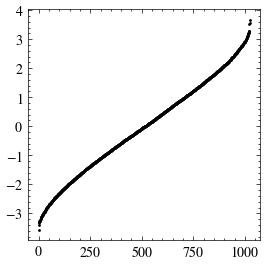

In [3]:
fig, ax = Plotter.get_subplots(1, 1, figsize=(3, 3))

model   = UltrametricModel(
    ns      = 10,
    n       = 3,
    alphas  = 0.8,
    backend = np
)

model.build()
model.diagonalize(verbose=True)

ax[0].plot(model.eig_val, 'o', ms = 1, color='black', label='Eigenvalues')
model

### Go through the model

<Axes: >

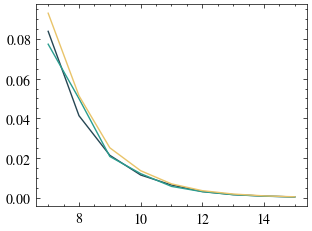

In [2]:

#! -------------------------------------------------------

rng                 = np.random.default_rng()
rand_num            = rng.integers(0, int(1e5))

#! -------------------------------------------------------

bw_df               = pd.read_csv("bw.csv", index_col=0, header=None, dtype=float)
mls_df              = pd.read_csv("mls.csv", index_col=0, header=None, dtype=float)
bw_df.index         = [f'{x:.2f}' for x in bw_df.index]
mls_df.index        = [f'{x:.2f}' for x in mls_df.index]
bw_df.columns       = list(range(7, 17))
mls_df.columns      = list(range(7, 16))
mls_df.iloc[0].plot()
mls_df.iloc[1].plot()
mls_df.iloc[-1].plot()

### Plot obtained results

In [5]:
def get_results_single(direct   : Directories, 
                        alpha   : float,
                        ns      : int,
                        n       : int,
                        uniform : bool = False,
                        ):
    
    #! -------------------------------------------------------
    model = UltrametricModel(
        ns      = ns,
        n       = n,
        alphas  = alpha
    )
    direct_in   = Directories(os.path.abspath(direct), 'uniform' if uniform else 'log', str(model))
    filelist    = direct_in.list_files(filters = [lambda x: str(x).endswith('h5')])
    if len(filelist) == 0:
        logger.warning(f"Files not found in {direct_in}")
        return None

    filelist        = [str(x) for x in filelist]
    filelist_stat   = [x for x in filelist if 'stat' in x   ]
    filelist_evo    = [x for x in filelist if 'evo'  in x   ]
    filelist_diag   = [x for x in filelist if 'dia'  in x   ]
    
    # logger.info(f"Found {len(filelist)} files in {direct_in}")
    # logger.info(f"Found {len(filelist_stat)} stat files in {direct_in}")
    # logger.info(f"Found {len(filelist_evo)} evo files in {direct_in}")
    # logger.info(f"Found {len(filelist_diag)} diag files in {direct_in}")
    
    #! -------------------------------------------------------
    data_stat   = [
        HDF5Handler.read_hdf5(x, logger=logger, verbose=False)
        for x in filelist_stat
    ]
    data_diag   = [
        HDF5Handler.read_hdf5(x, logger=logger, verbose=False)
        for x in filelist_diag
    ]
    data_evo    = [
        HDF5Handler.read_hdf5(x, logger=logger, verbose=False)
        for x in filelist_evo
    ]
    
    data_out = {
        'f_functions' : dadata_statta_out['']
    }

    #! -------------------------------------------------------
    
    
    
    

In [6]:
alphas          = np.arange(0.62, 1.0, 0.12)
sites           = np.arange(8, 12, dtype=int)
n               = 1
for alpha in alphas:
    for ns in sites:
        y = get_results_single(
            direct   = data_dir,
            alpha    = alpha,
            ns       = ns,
            n        = n,
            uniform  = True
        )
y

NameError: name 'dadata_statta_out' is not defined

### Evolve

In [3]:
def _process_single_realisation(
    ns              : int,
    alpha           : float,
    op_mats_items   : list,
    time_steps      : np.ndarray,
    hilbert_size    : int,
    omegas_alloc    : np.ndarray,
    vals_alloc      : np.ndarray):
    
    """Builds model, extracts overlaps, histograms & time-series for one realisation."""
    
    #! 1) build & diag
    model = UltrametricModel(ns=ns, n=1, alphas=alpha, backend=np, seed=None)
    model.build()
    model.diagonalize(verbose=False)
    
    eig_val     = model.eig_val
    eig_vec     = model.eig_vec
    eig_mean    = model.av_en
    bw          = model.get_bandwidth()

    #! 2) quench-state overlaps
    i0          = int(np.argmin(np.abs(eig_val - eig_mean)))
    quench      = np.zeros(hilbert_size, dtype=float)
    quench[i0]  = 1.0
    ov          = eig_vec.T @ quench
    ov2         = ov * ov
    quench_t    = time_evo.time_evo_block(eig_vec, eig_val, quench_overlaps=ov, times=time_steps)

    #! 3) LDOS + diagonal ensemble
    ldos_r      = statistical.ldos(energies=eig_val, overlaps=ov)
    # diag_e      = { name: time_evo.diagonal_ensemble(soverlaps=ov**2, diag_mat=(quench_t.T @ eig_vec).diagonal()) for name, _ in op_mats_items }
    
    #! 4) Matrix elements & histogram contributions
    hist_av     = {}
    diagonal_ens= {}
    for name, M in op_mats_items:
        mat_el              = overlap(eig_vec, M)
        diagonal_ens[name]  = time_evo.diagonal_ensemble(soverlaps=ov2, diag_mat=mat_el.diagonal())
        counter             = f_function(0, hilbert_size,
                                        overlaps            =   mat_el,
                                        eigvals             =   eig_val,
                                        omegas_allocated    =   omegas_alloc,
                                        vals_allocated      =   vals_alloc,
                                        energy_target       =   eig_mean,
                                        bw                  =   bw,
                                        energy_diff_cut     =   0.015)
        omegas, m2          = omegas_alloc[:counter], vals_alloc[:counter]
        mask                = (m2 > 1e-10) & np.isfinite(m2)
        hist_av[name]       = (omegas[mask], m2[mask])
        
    #! 5) time‐evolution expectation values
    te_vals = { name: np.real(time_evo.time_evo_evaluate(quench_t, M)) for name, M in op_mats_items }
    
    return {
        'bandwidth' :  bw,
        'ldos'      :  ldos_r,
        'energies'  :  eig_val,
        'diag_ens'  :  diagonal_ens,
        'hist'      :  hist_av,
        'time'      :  te_vals
    }

In [ ]:
def prepare_evolution(sites, 
                alphas,
                n_realisations  : dict, 
                time_num        : int, 
                operators_map   : dict,
                uniform         : bool = True):
    
    #! allocate the data
    max_nh              = 2**(sites[-1])
    max_allocated       = max_nh * (max_nh - 1) // 2
    global vals_allocated, omegas_allocated
    vals_allocated      = np.zeros(max_allocated, dtype=np.float64)
    omegas_allocated    = np.zeros(max_allocated, dtype=np.float64)
    
    histograms_av       = { op: {alpha: {} for alpha in alphas} for op in operators_map }
    histograms_typ      = { op: {alpha: {} for alpha in alphas} for op in operators_map }
    bandwidths          = { alpha: [] for alpha in alphas }
    
    #! loop over the sites
    for ins, ns in enumerate(sites):
        logger.info(f"ns = {ns}", lvl=1, color='blue')
        
        hilbert_size        = 2**ns
        n_realisations_in   = n_realisations[ns]
        
        # operators_map[sig_z_l(ns).name] = sig_z_l
        operators           = {k : v(ns) for k, v in operators_map.items()                                                          }
        operators_mat       = {k : op.matrix(dim=hilbert_size) for k, op in operators.items()                                       }
        
        #! energy and bandwidth
        ldos                = np.zeros(shape=(n_realisations_in, hilbert_size), dtype=np.float64)
        energies            = np.zeros(shape=(n_realisations_in, hilbert_size), dtype=np.float64)
        diagonals_operators = { k : np.zeros(shape=(n_realisations_in, hilbert_size), dtype=np.float64) for k in operators.keys()   }
        
        time_vals           = { k : np.zeros(shape=(n_realisations_in, time_num), dtype=np.float64) for k in operators.keys()       }
        diagonal_ensembles  = { k : np.zeros(shape=(n_realisations_in,), dtype=np.float64) for k in operators.keys()                }
        idx                 = 0
        
        #! go through the alphas
        for ia, alpha in enumerate(alphas):
            time_start_a        = time.perf_counter()
            logger.info(f"ns = {ns}, alpha = {alpha:.2f}", lvl=2, color='green')
            
            heisenberg_time     = 1.0 / mls_df.loc[f'{alpha:.2f}', ns] * 2.0 * np.pi
            bandwidth_data      = bw_df.loc[f'{alpha:.2f}', ns]
            time_delta          = 2.0 * np.pi / bandwidth_data
            time_start          = heisenberg_time - time_num * time_delta / 2
            if (time_start < 0.0):
                time_start      = heisenberg_time / 100
            quench_energies     = np.zeros((n_realisations_in,), dtype=np.float64)
            #! time evolution
            if uniform:
                time_steps      = np.linspace(time_start, time_start + time_delta * time_num, num=time_num)
            else:
                time_steps      = np.logspace(-2, np.log10(hilbert_size * 100), num=time_num)
                    
            #! histogram
            o_max               = 3 * bandwidth_data
            o_min               = 0.01 / hilbert_size
            n_bins              = int(20 * ns)
            edges               = HistogramAverage.uniform_log(n_bins, v_max=o_max, v_min=o_min)
            for name in operators.keys():
                h_av    = { k : HistogramAverage(n_bins, edges=edges) for k in operators.keys() }
                h_typ   = { k : HistogramAverage(n_bins, edges=edges) for k in operators.keys() }

            #! model
            model               = UltrametricModel(
                                        ns      = ns,
                                        n       = 1,
                                        alphas  = alpha,
                                        backend = np,
                                        seed    = None)
            
            #! directories
            data_dir_in = data_dir.join('uniform' if uniform else 'log', f'{str(model)}')
            data_dir_in.mkdir()
            
            #! go through the realisations
            for r in range(n_realisations_in):
                time_start_r    = time.perf_counter()
                logger.info(f"ns = {ns}, alpha = {alpha:.2f}, r = {r}", lvl=3, color='red')

                #! build & diag
                # model.clear()
                model.build()
                model.diagonalize(verbose=True)
                mean_energy     = model.av_en
                bandwidth       = model.get_bandwidth()
                bandwidths[alpha].append(bandwidth)
                
                #! select the quench state
                quench_state            = np.zeros(hilbert_size, dtype=np.float64)
                diff                    = np.abs(model.hamil.diagonal() - mean_energy)
                idx                     = int(np.argmin(diff)) # find the closest eigenvalue
                quench_state[idx]       = 1.0 # set the quench state
                quench_energies[r]      = overlap(quench_state, model.hamil)
                overlaps                = model.eig_vec.T @ quench_state
                soverlaps               = np.square(np.abs(overlaps))
                quench_states_t         = time_evo.time_evo_block(model.eig_vec, model.eig_val, quench_overlaps=overlaps, times=time_steps)
                
                #! compute the ldos
                ldos[r, :]              = statistical.ldos(energies = model.eig_val, overlaps = overlaps)
                energies[r, :]          = model.eig_val
                    
                #! accumulate into the single histogram
                if True:
                    for name in operators.keys():
                        matrix_elements                 = overlap(model.eig_vec, operators_mat[name])
                        diagonals_operators[name][r, :] = matrix_elements.diagonal()
                        diagonal_ensembles[name][r]     = time_evo.diagonal_ensemble(soverlaps=soverlaps, diag_mat=matrix_elements.diagonal())

                        cnt = statistical.f_function(
                            start               = 0,
                            stop                = len(model.eig_vec),
                            overlaps            = matrix_elements,
                            eigvals             = model.eig_val,
                            omegas_allocated    = omegas_allocated,
                            vals_allocated      = vals_allocated,
                            energy_target       = mean_energy,
                            bw                  = bandwidth,
                            energy_diff_cut     = 0.015)
                        
                        #! remove zeros and nan
                        omegas                  = omegas_allocated[:cnt]
                        vals                    = vals_allocated[:cnt]
                        mask                    = np.logical_and(vals > 1e-10, np.isfinite(vals))
                        omegas                  = omegas[mask]
                        vals                    = vals[mask]
                        h_av[name].append(omegas, vals)
                        h_typ[name].append(omegas, np.log(vals))
                        
                        #! time evolution
                        quenched_values_t       = time_evo.time_evo_evaluate(quench_states_t, operators_mat[name])
                        time_vals[name][r, :]   = np.real(quenched_values_t)
                logger.info(f"ns = {ns}, alpha = {alpha:.2f}, r = {r} done in {time.perf_counter() - time_start_r:.2f} s", lvl=4, color='red')
            #! store the combined histogram for this (ns,alpha)
            for name in operators:
                histograms_av[name][alpha][ns]  = h_av[name]
                histograms_typ[name][alpha][ns] = h_typ[name]
            
            #! save the data
            if True:
                data_stat = {
                    'bandwidth' : bandwidth,
                    'energies'  : energies,
                    'ldos'      : ldos,
                }
                #! statistical
                HDF5Handler.save_hdf5(directory =   data_dir_in, 
                                    filename    =   f'stat_{rand_num}.h5',
                                    data        =   data_stat)
                data_hist = {
                    'historgram/edges'  : histograms_av[name][alpha][ns].bin_edges,
                    'historgram/counts' : histograms_av[name][alpha][ns].counts(),
                }
                for name in operators.keys():
                    data_hist.update({
                        f'historgram/{name}/average/values' : histograms_av[name][alpha][ns].averages_av(),
                        f'historgram/{name}/typical/values' : histograms_av[name][alpha][ns].averages_av(is_typical=True),
                    })
                HDF5Handler.save_hdf5(directory =   data_dir_in,
                                    filename    =   f'hist_{rand_num}.h5', 
                                    data        =   data_hist)
                #! operator
                data_op = {
                    op : diag for op, diag in diagonals_operators.items()
                }
                HDF5Handler.save_hdf5(directory =   data_dir_in,
                                    filename    =   f'diag_{rand_num}.h5', 
                                    data        =   data_op)
                
                #! time evolution
                data_time = {
                    'time'                          : time_steps,
                    'time_evolution/quench/energy'  : quench_energies
                }
                data_time.update({
                    f'time_evolution/{name}/expectation' : time_vals[name] for name in operators.keys()
                })
                data_time.update({
                    f'time_evolution/{name}/diag_ens' : diagonal_ensembles[name] for name in operators.keys()
                })
                HDF5Handler.save_hdf5(directory =   data_dir_in,
                                    filename    =   f'evo_{rand_num}.h5', 
                                    data        =   data_time)
            logger.info(f"ns = {ns}, alpha = {alpha:.2f} done in {time.perf_counter() - time_start_a:.2f} s", lvl=2, color='green')
            
    return histograms_av, histograms_typ, bandwidths
#! -------------------------------------------------------

#### Logarithmic

In [7]:
alphas          = np.arange(0.62, 1.0, 0.12)
sites           = np.arange(8, 12, dtype=int)
# sites           = np.arange(6, 7, dtype=int)
n_realisations  = {ns: 5 for ns in sites}
# n_realisations  = {ns: 5 * (10 * (np.max(sites) - np.min(sites)) - 10 * (ns - np.min(sites)) + 1) for ns in sites}
time_num        = 40000

#! -------------------------------------------------------

operators_map = {
    sig_z_0(0).name : sig_z_0,
    # sig_z_c(0).name : sig_z_c,
}

#! -------------------------------------------------------

logger.info(f"Number of realisations: {n_realisations}")
logger.info(f"Number of sites: {len(sites)}")
logger.info(f"Alphas: {alphas}")
logger.info(f"Sites: {sites}")

histograms_av, histograms_typ, bandwidths = prepare_evolution(
    sites           = sites,
    alphas          = alphas,
    n_realisations  = n_realisations,
    time_num        = time_num,
    operators_map   = operators_map,
    uniform         = False
)

21_05_2025_08-32_07 [INFO] Number of realisations: {8: 5, 9: 5, 10: 5, 11: 5}
21_05_2025_08-32_07 [INFO] Number of sites: 4
21_05_2025_08-32_07 [INFO] Alphas: [0.62 0.74 0.86 0.98]
21_05_2025_08-32_07 [INFO] Sites: [ 8  9 10 11]
21_05_2025_08-32_07 [INFO] 	->ns = 11
21_05_2025_08-32_07 [INFO] 		->[HilbertSpace] Inferred Ns=11 from Nh=2048 and Nhl=2
21_05_2025_08-32_08 [INFO] 		->ns = 11, alpha = 0.62
21_05_2025_08-32_08 [INFO] 			->ns = 11, alpha = 0.62, r = 0
21_05_2025_08-32_08 [INFO] 	->[Hamiltonian] Diagonalization started using (standard)...
21_05_2025_08-32_08 [INFO] 		->[Hamiltonian] Diagonalization (standard) completed in 0.708050 seconds.
21_05_2025_08-32_13 [INFO] 			->ns = 11, alpha = 0.62, r = 1
21_05_2025_08-32_13 [INFO] 	->[Hamiltonian] Diagonalization started using (standard)...
21_05_2025_08-32_14 [INFO] 		->[Hamiltonian] Diagonalization (standard) completed in 0.693781 seconds.
21_05_2025_08-32_17 [INFO] 			->ns = 11, alpha = 0.62, r = 2
21_05_2025_08-32_17 [INFO] 	->[

#### Uniform

In [8]:
alphas          = np.arange(0.74, 1.0, 0.12)
sites           = np.arange(13, 14, dtype=int)
n_realisations  = {ns: 8 * (10 * (np.max(sites) - np.min(sites)) - 10 * (ns - np.min(sites)) + 1) for ns in sites}
time_num        = 40000

#! -------------------------------------------------------

operators_map = {
    sig_z_0(0).name : sig_z_0,
    # sig_z_c(0).name : sig_z_c,
}

#! -------------------------------------------------------

logger.info(f"Number of realisations: {n_realisations}")
logger.info(f"Number of sites: {len(sites)}")
logger.info(f"Alphas: {alphas}")
logger.info(f"Sites: {sites}")

histograms_av, histograms_typ, bandwidths = prepare_evolution(
    sites           = sites,
    alphas          = alphas,
    n_realisations  = n_realisations,
    time_num        = time_num,
    operators_map   = operators_map,
    uniform         = True
)

21_05_2025_23-48_10 [INFO] Number of realisations: {13: 8}
21_05_2025_23-48_10 [INFO] Number of sites: 1
21_05_2025_23-48_10 [INFO] Alphas: [0.74 0.86 0.98]
21_05_2025_23-48_10 [INFO] Sites: [13]
21_05_2025_23-48_10 [INFO] 	->ns = 13
21_05_2025_23-48_10 [INFO] 		->[HilbertSpace] Inferred Ns=13 from Nh=8192 and Nhl=2
21_05_2025_23-48_11 [INFO] 		->ns = 13, alpha = 0.74
21_05_2025_23-48_11 [INFO] 			->ns = 13, alpha = 0.74, r = 0
21_05_2025_23-48_15 [INFO] 	->[Hamiltonian] Diagonalization started using (standard)...
21_05_2025_23-48_36 [INFO] 		->[Hamiltonian] Diagonalization (standard) completed in 20.931688 seconds.
21_05_2025_23-49_07 [INFO] 				->ns = 13, alpha = 0.74, r = 0 done in 56.77 s
21_05_2025_23-49_07 [INFO] 			->ns = 13, alpha = 0.74, r = 1
21_05_2025_23-49_13 [INFO] 	->[Hamiltonian] Diagonalization started using (standard)...
21_05_2025_23-49_33 [INFO] 		->[Hamiltonian] Diagonalization (standard) completed in 20.311007 seconds.
21_05_2025_23-50_05 [INFO] 				->ns = 13, alp

#### Info

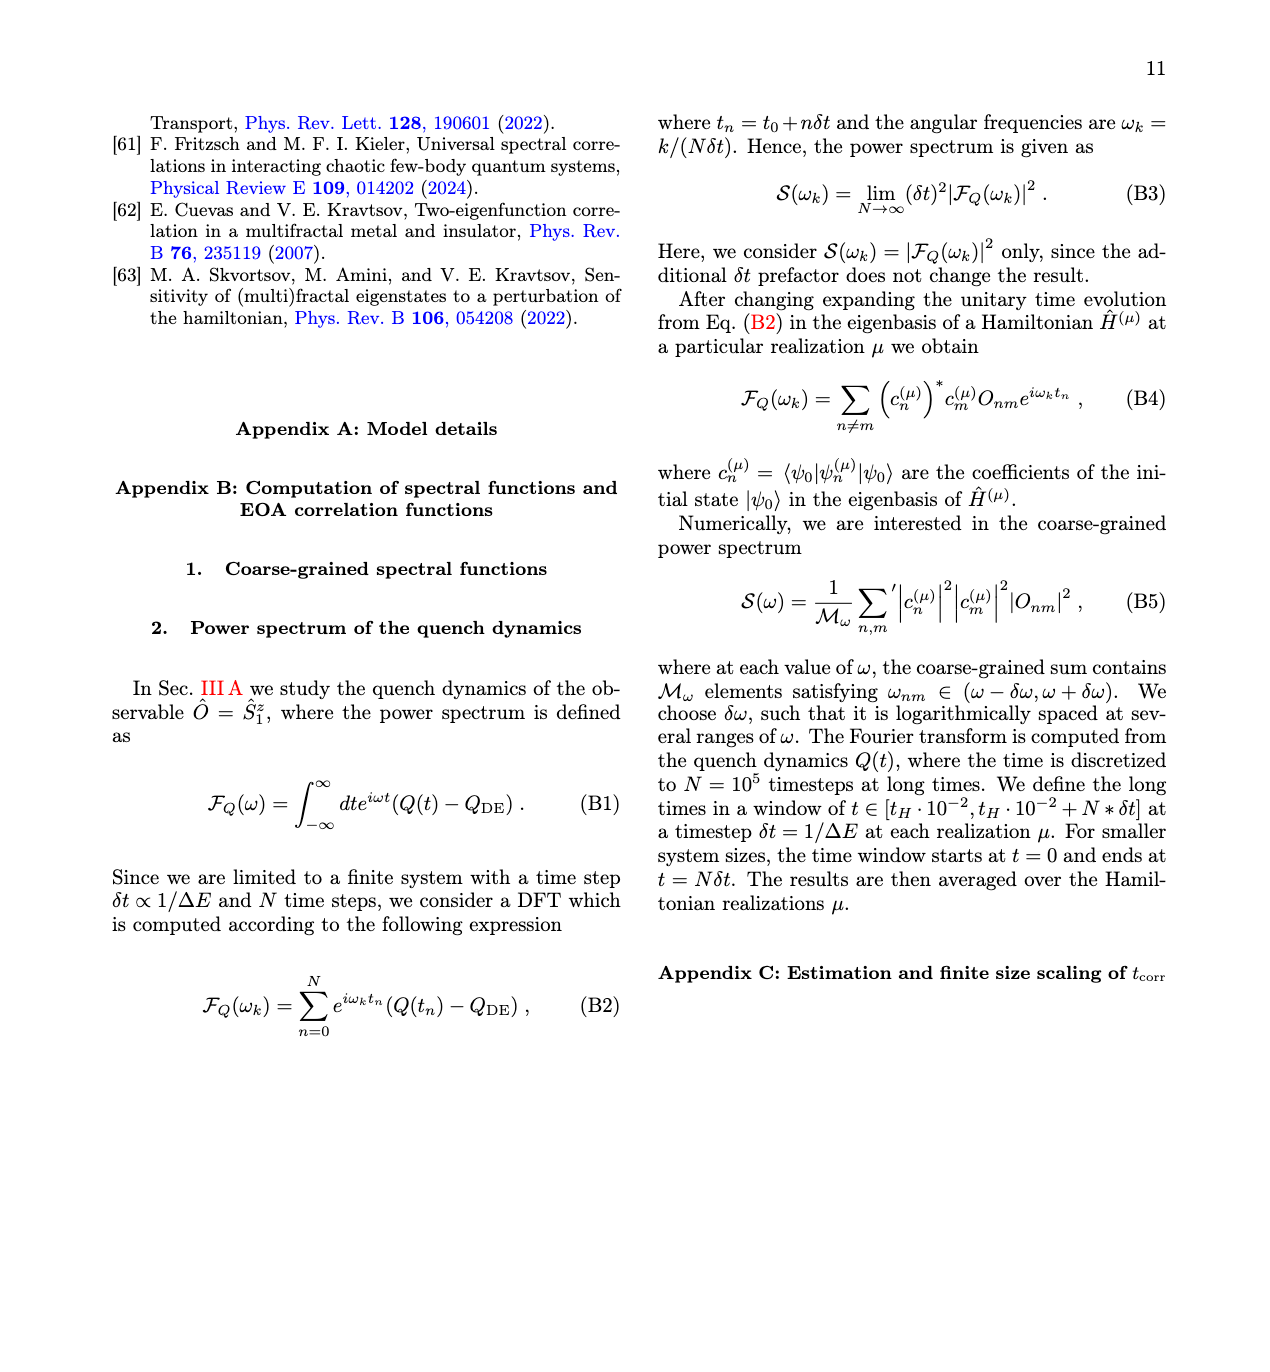

#### Spectral

/tmp/ipykernel_4148253/2570678771.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axis.legend(frameon=True, loc='upper right', fontsize=6)
/tmp/ipykernel_4148253/2570678771.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


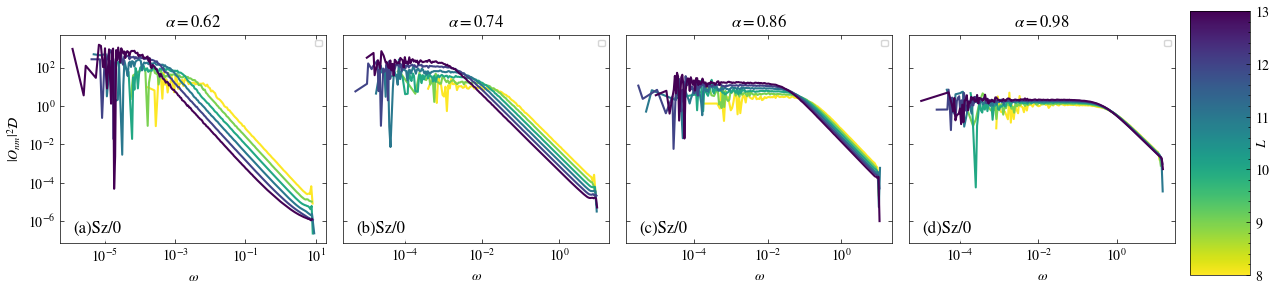

In [ ]:
fig, ax = Plotter.get_subplots(
    nrows    = len(operators_map),
    ncols    = len(alphas),
    figsize  = (3*len(alphas), 3*len(operators_map)),
    sharey   = True
)
getcolor, colors, norm = Plotter.get_colormap(sites, cmap='viridis_r')
Plotter.add_colorbar_pos(fig, colors, 
                        mapable =    sites,
                        pos     =   (1.0, 0.08, 0.05, 0.88), ylabel=r'$L$', ylabelcords=(1.1, 0.5)
                    )
typical = False

for op_idx, (op_name, _) in enumerate(operators_map.items()):
    for alpha_idx, alpha in enumerate(alphas):
        idx_ax  = op_idx * len(alphas) + alpha_idx
        axis    = ax[idx_ax]
        Plotter.set_annotate_letter(axis, idx_ax, x = 0.05, y = 0.05, addit = op_name)
        #! plot each ns into the same histogram
        for ns in sites:
            h : HistogramAverage    = (histograms_typ if typical else histograms_av)[op_name][alpha][ns]
            vals                    = h.averages_av()
            # counts                  = h.counts_col()
            # one mask for >0, finite
            if not typical:
                mask = (vals > 1e-10) & np.isfinite(vals)
            else:
                mask = (vals < -1e-10) & np.isfinite(vals)
            if not mask.any():
                continue
            if typical:
                vals = np.exp(vals) * 2**ns
            else:
                vals = vals * 2**ns

            axis.plot(h.bin_edges[mask], vals[mask], lw=1.5, color=getcolor(ns))

        # log–log and fixed y-range
        axis.set_xscale('log')
        axis.set_yscale('log')
        # axis.set_ylim(1e-4, None)

        # only bottom row gets the x-label
        if op_idx == len(operators_map) - 1:
            axis.set_xlabel(r'$\omega$')

        # only first column gets the y-label
        if alpha_idx == 0:
            axis.set_ylabel(r'$|O_{nm}|^2 \mathcal{D}$')

        # legend in bottom of each column (or top-right of bottom row)
        if op_idx == len(operators_map) - 1:
            axis.legend(frameon=True, loc='upper right', fontsize=6)

        # optional: put alpha in the column title on top row
        if op_idx == 0:
            axis.set_title(f"$\\alpha = {alpha:.2f}$")

fig.tight_layout()
